# Quara Questions similarity

In [1]:
import matplotlib.pyplot as plt
import re
import time
import warnings
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import numpy as np
from tqdm import tqdm
from joblib import dump, load

# importing Cross validation libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from collections import Counter, defaultdict

import pandas as pd
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from collections import Counter
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier


import scipy.sparse as sp

from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [4]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### Common functions

In [6]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    
    
    
depth_ = [2,3,5,7,9]
depth_ = np.asarray(depth_)

estimators = [100,500,1000,1200,1300]
estimators_list = np.asarray(estimators)

colsample_bytree = [0.1, 0.3, 0.5, 0.7]
colsample_bytree = np.asarray(colsample_bytree)

subsample = [0.1,0.3,0.5,0.7]
colsample_bytree = np.asarray(subsample)


def finding_best_hyperparam(X_tr,y_tr):
    # instantiate a GBDT model
    xgb = XGBClassifier(class_weight='balanced', random_state=1)
    
    cross_val = StratifiedKFold(n_splits=5, shuffle=True)

    param_grid=dict(n_estimators=estimators_list,max_depth=depth_,colsample_bytree = colsample_bytree,
                      subsample = subsample) 
    
    # instantiate the training random search model
    train_grid = RandomizedSearchCV(xgb, param_grid, cv=cross_val, scoring='neg_log_loss',n_jobs =-1,verbose=8 )
    
    # fit the training data to train model
    train_grid.fit(X_tr, y_tr)

    return train_grid

## 1. TFIDF

In [7]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [8]:
# drop 'qid1' and 'qid2'
dfppro = dfppro.drop(['qid1','qid2'],axis=1)

# drop 'qid1','qid2', 'question1', 'question2','is_duplicate'
dfnlp = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

# join operation
df_final_features  = dfppro.merge(dfnlp, on='id',how='left')

In [12]:
df_final_features.columns

Index(['id', 'question1', 'question2', 'is_duplicate', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [13]:
# not null check
df_final_features = df_final_features[df_final_features['question1'].notnull()]
df_final_features = df_final_features[df_final_features['question2'].notnull()]

In [14]:
y = df_final_features['is_duplicate'][:100000]

## 3. Split data


In [15]:
X = df_final_features[:100000]

X_train,X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,random_state=0)
X_train, X_cv, y_train, y_cv = model_selection.train_test_split(X_train, y_train, test_size=0.20) # this is random splitting


X_train.shape, X_test.shape,X_cv.shape, y_train.shape, y_test.shape, y_cv.shape

((64000, 30), (20000, 30), (16000, 30), (64000,), (20000,), (16000,))

In [16]:
tfidf =  TfidfVectorizer(ngram_range=(1,3), min_df=10) #in scikit-learn

X_tr_tfidf_vect1 = tfidf.fit_transform(X_train['question1'])
X_cv_tfidf_vect1 = tfidf.transform(X_cv['question1'])
X_test_tfidf_vect1 = tfidf.transform(X_test['question1'])

X_tr_tfidf_vect2 = tfidf.fit_transform(X_train['question2'])
X_cv_tfidf_vect2 = tfidf.transform(X_cv['question2'])
X_test_tfidf_vect2 = tfidf.transform(X_test['question2'])

In [17]:
X_train.columns

Index(['id', 'question1', 'question2', 'is_duplicate', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [18]:
# as we need only features data, we can eliminate unneccasary
X_train.drop(['id','is_duplicate','question1','question2'], axis=1, inplace=True)
X_cv.drop(['id','is_duplicate','question1','question2'], axis=1, inplace=True)
X_test.drop(['id','is_duplicate','question1','question2'], axis=1, inplace=True)

In [19]:
# https://stackoverflow.com/questions/34710281/use-featureunion-in-scikit-learn-to-combine-two-pandas-columns-for-tfidf
# dtype=np.float64 will convert string to numeric features

# stacking tfidf_que1 with tfidf_que2
X_tr_stack = sp.hstack([X_tr_tfidf_vect1, X_tr_tfidf_vect2], format='csr', dtype='float64')

# stacking all features
X_train = sp.hstack((X_train, X_tr_stack),format="csr",dtype='float64')

X_cv_stack = sp.hstack([X_cv_tfidf_vect1, X_cv_tfidf_vect2], format='csr', dtype='float64')
X_cv  = sp.hstack((X_cv, X_cv_stack),format="csr",dtype='float64')

X_test_stack = sp.hstack([X_test_tfidf_vect1, X_test_tfidf_vect2], format='csr', dtype='float64')
X_test  = sp.hstack((X_test, X_test_stack),format="csr",dtype='float64')

X_train.shape, X_test.shape,X_cv.shape, y_train.shape, y_test.shape, y_cv.shape

((64000, 29191), (20000, 29191), (16000, 29191), (64000,), (20000,), (16000,))

In [20]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6275 Class 1:  0.3725
---------- Distribution of output variable in train data ----------
Class 0:  0.3787 Class 1:  0.3787


## 2. Building a random model (Finding worst-case log-loss) 

Log loss on Test Data using Random Model 0.8849129142714491


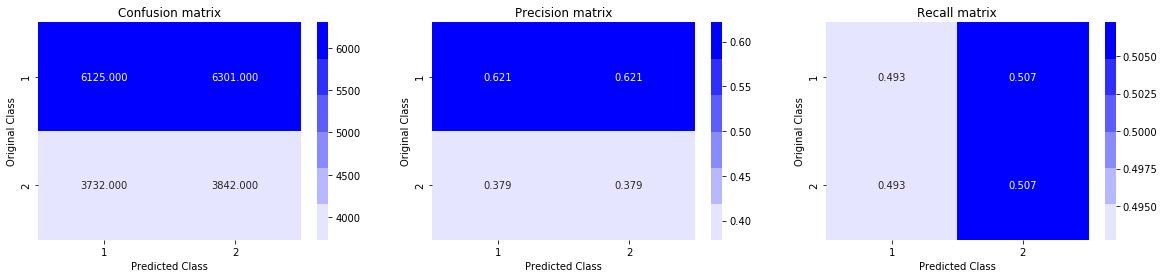

In [21]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## 4. Machine Learning Models

## 4.1 Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.44876895419894147
For values of alpha =  0.0001 The log loss is: 0.44198186097701403
For values of alpha =  0.001 The log loss is: 0.4471844116688919
For values of alpha =  0.01 The log loss is: 0.4448723999609054
For values of alpha =  0.1 The log loss is: 0.451698897035198
For values of alpha =  1 The log loss is: 0.48990628376450607
For values of alpha =  10 The log loss is: 0.549087506232412


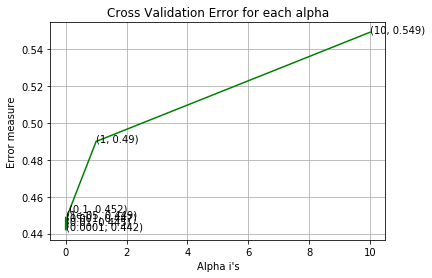

For values of best alpha =  0.0001 The train log loss is: 0.4492720654380141
For values of best alpha =  0.0001 The test log loss is: 0.44198186097701403
Total number of data points : 20000


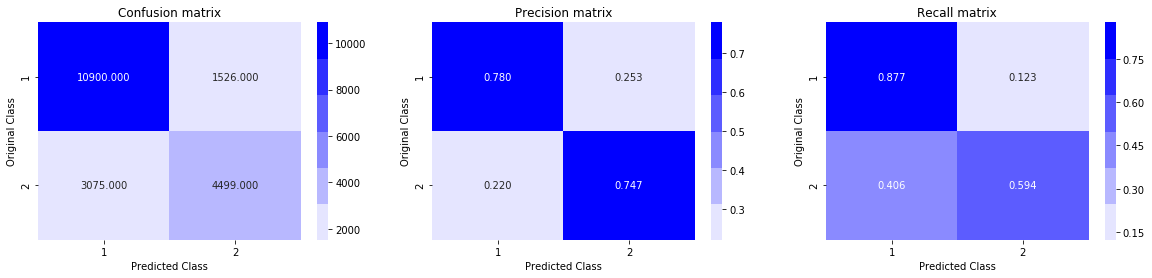

In [30]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 4.2 Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.4564755096759054
For values of alpha =  0.0001 The log loss is: 0.4816810055256412
For values of alpha =  0.001 The log loss is: 0.48871223690306725
For values of alpha =  0.01 The log loss is: 0.49865661077196854
For values of alpha =  0.1 The log loss is: 0.4892970712272376
For values of alpha =  1 The log loss is: 0.5805943036947876
For values of alpha =  10 The log loss is: 0.6336572993591096


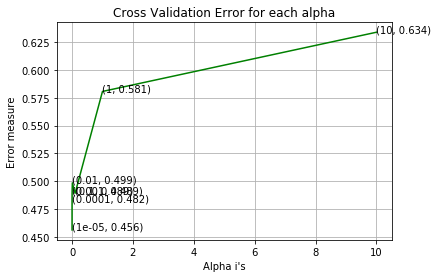

For values of best alpha =  1e-05 The train log loss is: 0.4648256994859472
For values of best alpha =  1e-05 The test log loss is: 0.4564755096759054
Total number of data points : 20000


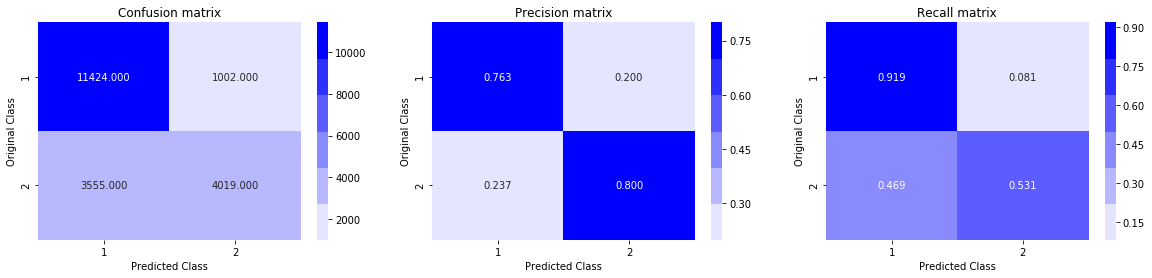

In [31]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 4.3 Hyperparam Tuning using XGBOOST

In [24]:
hyp_train_= finding_best_hyperparam(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 22.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 22.2min finished


In [25]:
print("Best: %f using %s" % (hyp_train_.best_score_, hyp_train_.best_params_))
print('=='*50)
means = hyp_train_.cv_results_['mean_test_score']
params = hyp_train_.cv_results_['params']

for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -0.330698 using {'subsample': 0.5, 'n_estimators': 1200, 'max_depth': 3, 'colsample_bytree': 0.5}
-0.330698 with: {'subsample': 0.5, 'n_estimators': 1200, 'max_depth': 3, 'colsample_bytree': 0.5}
-0.339120 with: {'subsample': 0.7, 'n_estimators': 1000, 'max_depth': 2, 'colsample_bytree': 0.7}
-0.367988 with: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 3, 'colsample_bytree': 0.3}
-0.360434 with: {'subsample': 0.1, 'n_estimators': 1200, 'max_depth': 7, 'colsample_bytree': 0.1}
-0.358152 with: {'subsample': 0.1, 'n_estimators': 100, 'max_depth': 5, 'colsample_bytree': 0.3}
-0.386373 with: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 3, 'colsample_bytree': 0.1}
-0.353068 with: {'subsample': 0.1, 'n_estimators': 1000, 'max_depth': 2, 'colsample_bytree': 0.1}
-0.346672 with: {'subsample': 0.1, 'n_estimators': 500, 'max_depth': 3, 'colsample_bytree': 0.5}
-0.350379 with: {'subsample': 0.1, 'n_estimators': 1300, 'max_depth': 2, 'colsample_bytree': 0.1}
-0.335191 with: {'

In [26]:
xgb_model = XGBClassifier(class_weight='balanced', n_estimators=1300,max_depth=9,colsample_bytree = 0.5,
                      subsample = 0.5,random_state=1)

xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=0.5, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=1300, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

For values of best alpha =  1e-05 The train log loss is: 0.11545512084550494
For values of best alpha =  1e-05 The test log loss is: 0.3217635831075882
Total number of data points : 20000


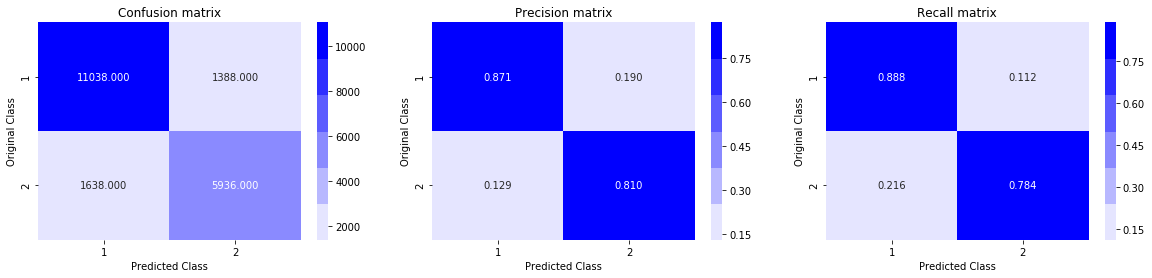

In [27]:
predict_y = xgb_model.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = xgb_model.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

Above we can see that though test loss it '0.32176' which is excellent on other it is also notice that train loss is '0.11545'

There is large difference between train loss and test lost so our model might be **OVERFIT**.

So we will adjust hyperparam tune values.

Try below values

max_depth = 5
n_estimators = 1000

For values of best alpha =  1e-05 The train log loss is: 0.23319731846422492
For values of best alpha =  1e-05 The test log loss is: 0.3188408678021985
Total number of data points : 20000


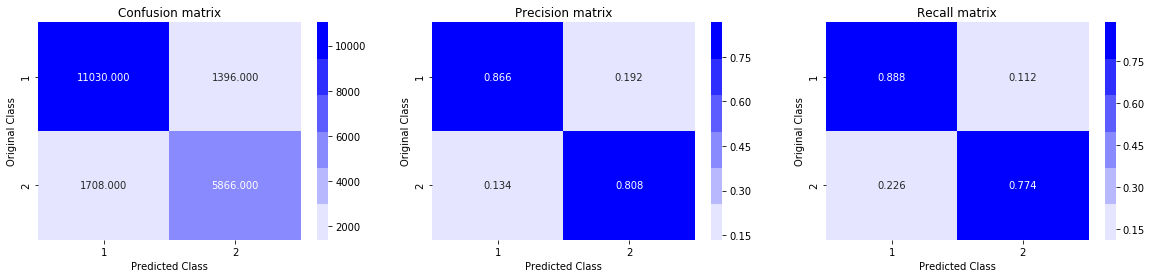

In [28]:
xgb_model = XGBClassifier(class_weight='balanced', n_estimators=1000,max_depth=5,colsample_bytree = 0.5,
                      subsample = 0.5,random_state=1)

xgb_model.fit(X_train,y_train)

predict_y = xgb_model.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = xgb_model.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 5. Conclusion

In [32]:
import pandas as pd
from prettytable import PrettyTable

print('\t\t\t\t Model Comparision  ')
print('\n')

print('We have considered 100k points')


x = PrettyTable()
x.field_names =  ['Metric','Random Model','Logistic Regression','Linear SVM', 'GBDT']

x.add_row(["Train Log Loss ",0.88491, 0.44927,0.46482,0.23319])
x.add_row(["Test Log Loss ",0.88491, 0.44198,0.45647,0.31884])


print('\n')
print(x)

				 Model Comparision  


We have considered 100k points


+-----------------+--------------+---------------------+------------+---------+
|      Metric     | Random Model | Logistic Regression | Linear SVM |   GBDT  |
+-----------------+--------------+---------------------+------------+---------+
| Train Log Loss  |   0.88491    |       0.44927       |  0.46482   | 0.23319 |
|  Test Log Loss  |   0.88491    |       0.44198       |  0.45647   | 0.31884 |
+-----------------+--------------+---------------------+------------+---------+


## Summary

We have built Logistic Regression, Linear SVM and GBDT based models. It is clear cut GBDT perfoming best in all of them.

Also it is notice that Train log loss and Test Log loss value are closer for all models so we can say that all mode performing well, no overfitting nothing

While performig GBDT we seems model was slightly tends to overfitt, but we adjust some value now its look better.

Logistic Regression and LinearSVM models work better in Higher Dimensions

It is rule of thumb that GBDT works better in small dimension, yet here in HIGHER dimension also it is working well.